# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [0]:
# From https://stackoverflow.com/questions/48875783/how-to-upload-many-files-to-google-colab
# Needed to be able to access CIFAR-10 data saved on my Google Drive
# Cell not needed to be run each time Colab notebook is opened but seems to be needed when notebook opened for first time in a while

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive

In [1]:
# Checking to see if directories on my Google Drive are accessible
!ls Drive/CS231n

Assignment_1


In [0]:
# Trying to import python modules from files stored on my Google Drive
# Following example here: http://www.pingshiuanchua.com/blog/post/importing-your-own-python-module-or-python-file-in-colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import random
import numpy as np

data_utils_module = drive.CreateFile({'id':'1Dxb8NfzUDqtRC3uNt_bRX4_Y3j5rHIZu'})
data_utils_module.GetContentFile('data_utils.py')

#from cs231n.data_utils import load_CIFAR10
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
features_module = drive.CreateFile({'id':'1_yUvNUvV3H0MMnk5daoPoT4iGNHpiH8g'})
features_module.GetContentFile('features.py')

#from cs231n.features import color_histogram_hsv, hog_feature
from features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    #cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    cifar10_dir = 'Drive/CS231n/Assignment_1/cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
#from cs231n.features import *
from features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [14]:
# Use the validation set to tune the learning rate and regularization strength

linear_svm_module = drive.CreateFile({'id':'1pM1Q2ciIu8mGgYOe3V-HGC8aMpEQvpGd'})
linear_svm_module.GetContentFile('linear_svm.py')

softmax_module = drive.CreateFile({'id':'1NvoZa_LkC_fftCtL5wCppw-9HEq-Fyxo'})
softmax_module.GetContentFile('softmax.py')

linear_classifier_module = drive.CreateFile({'id':'17rYYuBbRyUGsf0cHelmDu6NjS5ci-tyV'})
linear_classifier_module.GetContentFile('linear_classifier.py')

#from cs231n.classifiers.linear_classifier import LinearSVM
from linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None


import itertools

for lr_rs_pairs in itertools.product(learning_rates, regularization_strengths):
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr_rs_pairs[0], reg=lr_rs_pairs[1], num_iters=1500, batch_size=200)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(lr_rs_pairs[0], lr_rs_pairs[1])] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm

        
# Print out results.
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e rs %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-09 rs 1.000000e+05 train accuracy: 0.099653 val accuracy: 0.103000
lr 1.000000e-09 rs 1.000000e+06 train accuracy: 0.084082 val accuracy: 0.076000
lr 1.000000e-09 rs 1.000000e+07 train accuracy: 0.414429 val accuracy: 0.417000
lr 1.000000e-08 rs 1.000000e+05 train accuracy: 0.093245 val accuracy: 0.102000
lr 1.000000e-08 rs 1.000000e+06 train accuracy: 0.413347 val accuracy: 0.421000
lr 1.000000e-08 rs 1.000000e+07 train accuracy: 0.410694 val accuracy: 0.415000
lr 1.000000e-07 rs 1.000000e+05 train accuracy: 0.413531 val accuracy: 0.410000
lr 1.000000e-07 rs 1.000000e+06 train accuracy: 0.409163 val accuracy: 0.418000
lr 1.000000e-07 rs 1.000000e+07 train accuracy: 0.316898 val accuracy: 0.324000
best validation accuracy achieved: 0.421000


In [15]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


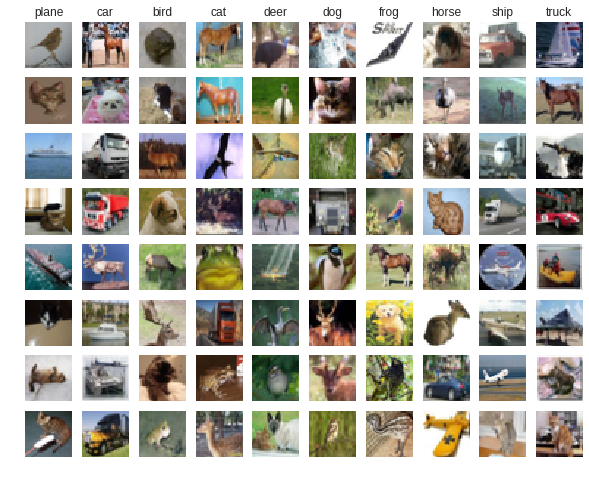

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**Your answer:** Many of the misclassifications happen because of color (e.g., lots of greens in the misclassifications of frogs, lots of blues in the boundary regions in the misclassifications of planes, etc.) or because of subtle differences between categories (e.g., several trucks appear in the misclassifications of cars).

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [17]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [35]:
neural_net_module = drive.CreateFile({'id':'1xKqcb0TdMpC093qLmz5jp5Kt86SgM5aO'})
neural_net_module.GetContentFile('neural_net.py')

#from cs231n.classifiers.neural_net import TwoLayerNet
from neural_net import TwoLayerNet

input_size = X_train_feats.shape[1]
num_classes = 10

hidden_sizes = [500]
learning_rates = [1e0]
num_iterations = [3000]
regularization_strengths = [1e-3]

# results is dictionary mapping tuples of the form
# (hidden_size, learning_rate, num_iterations, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_net = None # The TwoLayerNet object that achieved the highest validation rate.

for parameter_tuples in itertools.product(hidden_sizes, learning_rates, num_iterations, regularization_strengths):
    net = TwoLayerNet(input_size, parameter_tuples[0], num_classes)
    net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=parameter_tuples[1], reg=parameter_tuples[3], num_iters=parameter_tuples[2], batch_size=200)
    y_train_pred = net.predict(X_train_feats)
    y_val_pred = net.predict(X_val_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    validation_accuracy = np.mean(y_val == y_val_pred)
    results[(parameter_tuples[0], parameter_tuples[1], parameter_tuples[2], parameter_tuples[3])] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_net = net
        
# Print out results.
for hs, lr, ni, rs in sorted(results):
    train_accuracy, val_accuracy = results[(hs, lr, ni, rs)]
    print('hs %e lr %e ni %e rs %e train accuracy: %f val accuracy: %f' % (
                hs, lr, ni, rs, train_accuracy, val_accuracy))

hs 5.000000e+02 lr 1.000000e+00 ni 3.000000e+03 rs 1.000000e-03 train accuracy: 0.783041 val accuracy: 0.580000


In [36]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.59
